# Di-Alanina

In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
import mdtraj as md
import nglview as nv
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')

## Definición del sistema

Para este, y otros sistemas, acudiremos al [repositorio de sistemas de tests](https://github.com/choderalab/openmmtools/blob/master/openmmtools/testsystems.py) mantenido por la gente del laboratorio de John Chodera en [OpenMMTools](https://openmmtools.readthedocs.io/en/latest/). Echarle un ojo al mismo [fichero de definición de los sistemas](https://github.com/choderalab/openmmtools/blob/master/openmmtools/testsystems.py) puede resultarte muy instructivo.

In [3]:
import openmmtools as mmtools
from openmmtools import testsystems

Allí podemos encontrar varios sistemas listos para ser cargados. 

In [4]:
# dir(testsystems)

Entre ellos encontramos tres dipéptidos de alanina que podemos usar para nuestros tests: `AlanineDipeptideVacuum`, `AlanineDipeptideImplicit`, `AlanineDipeptideExplicit`. Haremos uso, por ser computacionalmente más barato, del dipéptido de alanina en vacio.

In [5]:
system = testsystems.AlanineDipeptideVacuum()

In [6]:
def make_view(omm_system):
    topology = omm_system.topology
    positions = omm_system.positions
    mdtraj_aux_topology = md.Topology.from_openmm(topology)
    traj_aux = md.Trajectory(positions/unit.nanometers, mdtraj_aux_topology)
    view = nv.show_mdtraj(traj_aux)
    view.center()
    return view

In [7]:
make_view(system)

NGLWidget()

# Estado termodinámico

In [8]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parámetros de la simulación

In [9]:
step_size       = 2*unit.femtoseconds
num_steps       = 400000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [10]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [11]:
platform_name = 'CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [12]:
num_atoms  = system.topology.getNumAtoms()
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,num_atoms,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,num_atoms,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [13]:
initial_positions  = system.positions
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system.system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [14]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [15]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 4000/4000 [07:18<00:00,  9.27it/s]


# Análisis de resultados

Accediendo a las posiciones:

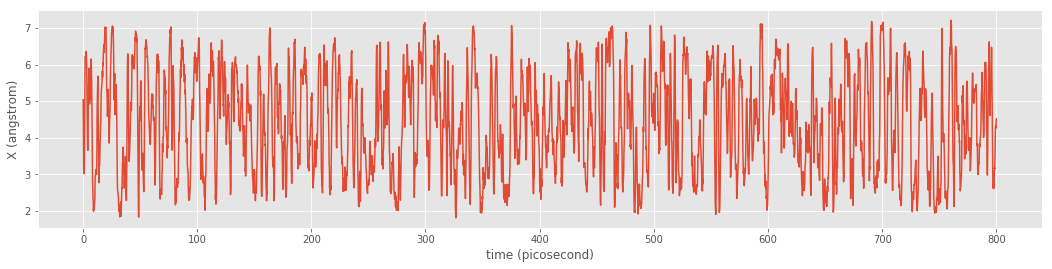

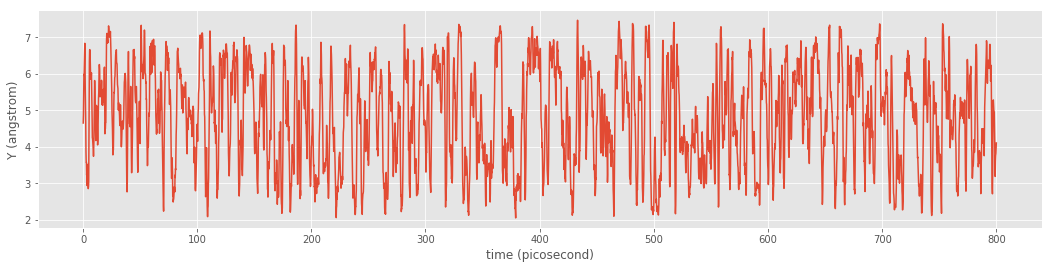

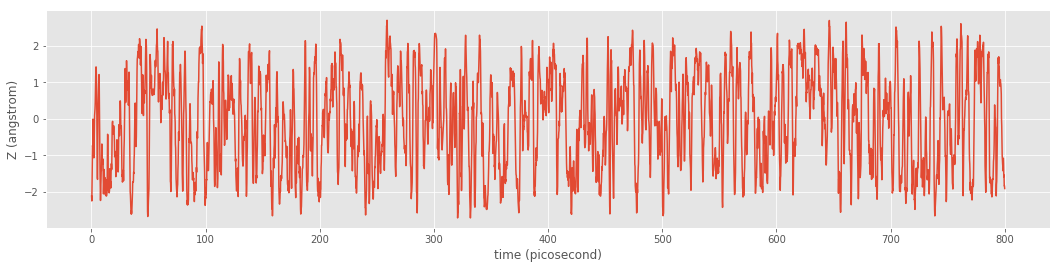

In [16]:
atom_index = 10 # Por ejemplo del átomo 10
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,atom_index,ii])
    plt.ylabel(ylabel+' ('+str(positions.unit)+')')
    plt.xlabel('time ('+str(times.unit)+')')
    plt.show()

Representando las energías cinética y potencial:

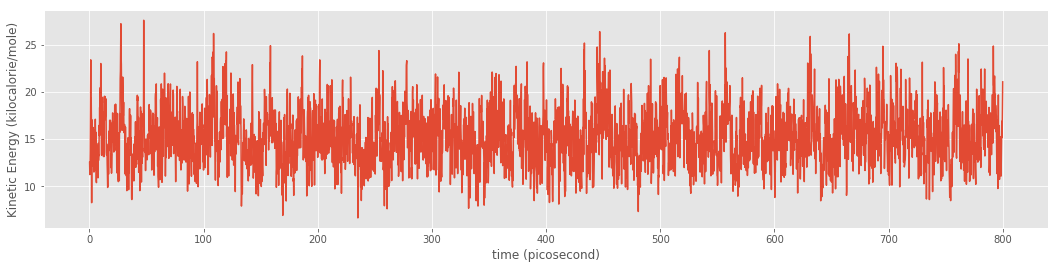

In [17]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,kinetic_energies[:])
plt.ylabel('Kinetic Energy ('+str(kinetic_energies.unit)+')')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

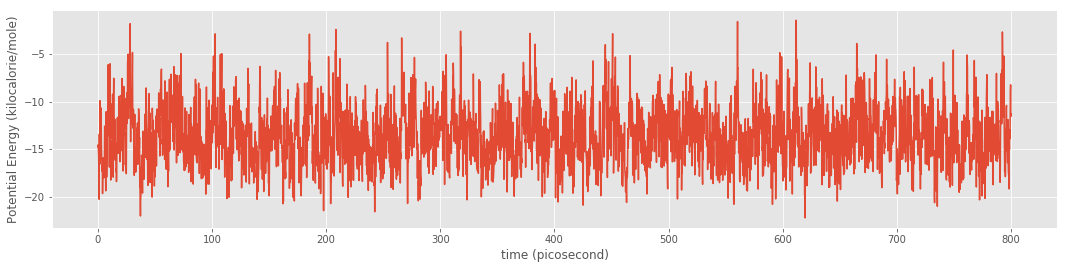

In [18]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,potential_energies[:])
plt.ylabel('Potential Energy ('+str(potential_energies.unit)+')')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

Represento la trayectoria centrada y fitteada según los átomos de la cadena principal:

In [19]:
mdtraj_topology = md.Topology.from_openmm(system.topology)
mdtrajectory    = md.Trajectory(positions/unit.nanometers, mdtraj_topology)

In [20]:
mdtrajectory = mdtrajectory.center_coordinates()
mdtrajectory = mdtrajectory.superpose(reference=mdtrajectory, frame=0, 
                                      atom_indices=mdtrajectory.topology.select("backbone"))

In [21]:
view_traj = nv.show_mdtraj(mdtrajectory)
view_traj

NGLWidget(count=4000)

Represento el RMSD de la trayectoria fitteada respecto del frame 0 según los átomos de la cadena principal

In [22]:
rmsd = md.rmsd(mdtrajectory, mdtrajectory, atom_indices=mdtrajectory.topology.select("backbone"))

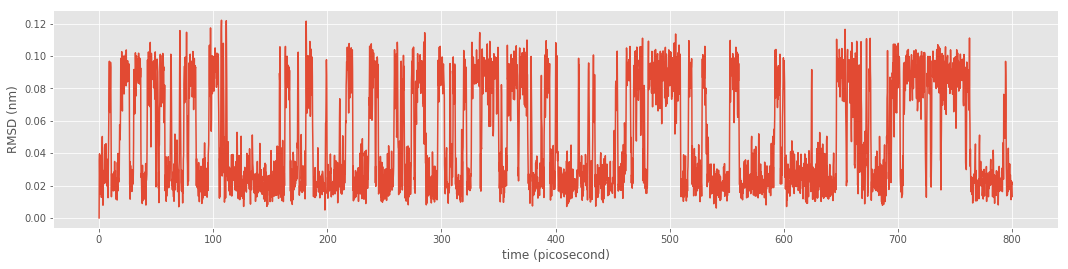

In [23]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,rmsd[:])
plt.ylabel('RMSD (nm)')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

Represento los pares de ángulos dihedros phi y psi visitados por la trayectoria sobre el plot de ramachandran.

In [24]:
phi   = md.compute_phi(mdtrajectory)
psi   = md.compute_psi(mdtrajectory)
omega = md.compute_omega(mdtrajectory)

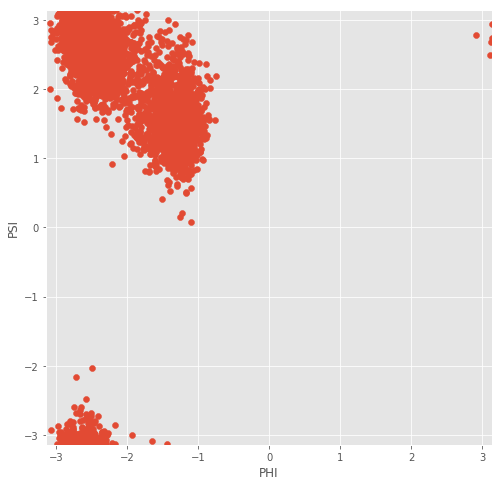

In [25]:
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(phi[1],psi[1])
plt.ylabel('PSI')
plt.xlabel('PHI')
plt.ylim(-np.pi,np.pi)
plt.xlim(-np.pi,np.pi)
plt.show()